In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend

import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [3]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-tot_chl_byfile/data?format=csv'
result = pd.read_csv(fileURL)
# pick out the subset of variables to use for clustering/PCA
print result.columns

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL)
sds.rename(columns={'file': 'File_Id', 'day': 'Day'}, inplace=True)
print sds.columns


Index([u'tot_chl', u'Cruise', u'Day', u'File_Id'], dtype='object')
Index([u'Day', u'LAT', u'LON', u'File_Id', u'T', u'S', u'Cruise'], dtype='object')


In [4]:
# join sds dataframe to opp file averages

print sds.shape
#print type(sds), type(cIdx[9])
#new_table = pd.merge(sds, result, how="inner")
new_table = pd.merge(sds, result, how="inner")


#X = new_table[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
X = new_table[['tot_chl']].values 

(69235, 7)


In [5]:
# identify continuous transects
# start by just picking out cruises that we know fit the bill

# look at how the clusters relate to physical properties of the water column...

cr = 'Thompson_1'
crsub = new_table[(new_table['Cruise']==cr)].sort(['Day','File_Id'],ascending=[1,1])
crsub['density'] = sw.rho(crsub['S'].values,crsub['T'].values,0)

cxx = (crsub['LON']).values # longitude
cyy = (crsub['LAT']).values # latitude

# convert all longitude to longitude east
cxx[cxx<0]= 360+cxx[cxx<0];
cxbew = cxx
cxbew[cxbew>180] = cxbew[cxbew>180]-360

# calculate distance between points
cdistance = sw.distance(cxbew,cyy, 0)[0]
ctrack = np.cumsum(cdistance)
ctrack = np.insert(ctrack, 0, 0)


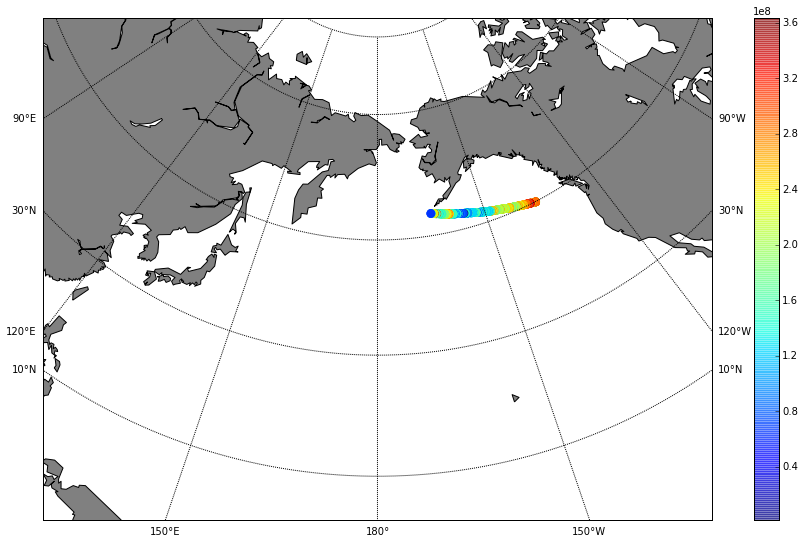

49.9373


53.747197

In [22]:
# plot the cruise track

fig1 = plt.figure(1, figsize=(15,9))

m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=60,lat_0=45,lon_0=-180.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(cxbew,cyy)
m.scatter(xm, ym, s=75, c=crsub['tot_chl'], alpha=.5,lw=0)

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])


plt.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar()
plt.show()

print cyy.min(); cyy.max()

In [6]:
# "continuous" tracks of data are found between 63:950 952:1015 1017:1371
# now turn these into 3 separate datasets, track1, track2 and track3
# check the lemgth of these tracks

t1 = ctrack[950]-ctrack[63] #1174km long
t2 = ctrack[1015]-ctrack[952] #108km long, this track is short and a bit dodgy
t3 = ctrack[1371]-ctrack[1017] #458km long

# split the subset into tracks
t1sub = crsub.iloc[63:950]
t2sub = crsub.iloc[952:1015]
t3sub = crsub.iloc[1017:1371]

# split the tracks
t1track = ctrack[63:950]-ctrack[63]
t2track = ctrack[952:1015]-ctrack[952]
t3track = ctrack[1017:1371]-ctrack[1017]


# check the effective resolution for the tracks
print cdistance[63:950].mean()/1000, cdistance[63:950].std()/1000
print cdistance[952:1015].mean()/1000, cdistance[952:1015].std()/1000
print cdistance[1017:1371].mean()/1000, cdistance[1017:1371].std()/1000


1.31809837483 0.819075028234
1.71442449262 1.82330681139
1.29587331212 1.0506613335


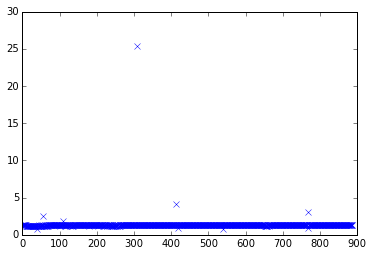

In [7]:
plt.plot(cdistance[63:950]/1000,'x')
plt.show()

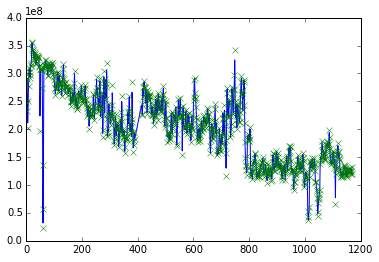

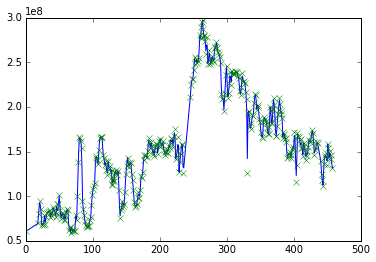

In [26]:
# interpolate the tracks onto a regular n km grid
# set the interpolation scale, n
n = 1

t1x = np.arange(0,t1+1000, n*1000)
t3x = np.arange(0,t3+1000, n*1000)
t1int = np.interp(t1x,t1track,t1sub['tot_chl'].values)
t3int = np.interp(t3x,t3track,t3sub['tot_chl'].values)

t1intT = np.interp(t1x,t1track,t1sub['T'].values)
t3intT = np.interp(t3x,t3track,t3sub['T'].values)

plt.plot(t1x/1000,t1int,t1track/1000,t1sub['tot_chl'].values,'x')
plt.show()

plt.plot(t3x/1000,t3int,t3track/1000,t3sub['tot_chl'].values,'x')
plt.show()

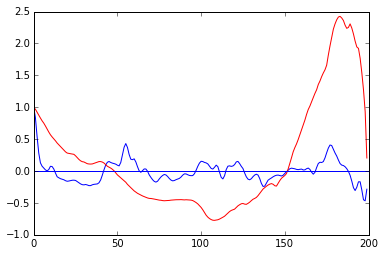

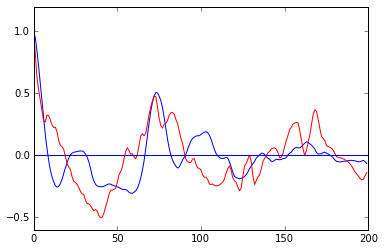

In [27]:
# grab subsets of each track, detrend them and do autocorrelation to get decorrelation length scale
# track 1

#plt.plot(t1x[0:100]/1000,detrend(t1int[0:100], order=1))
#plt.show()

#plt.plot(t3x[0:100]/1000,detrend(t3int[0:100], order=1))
#plt.show()
plt.hold(True)
plt.plot(ccf(detrend(t1int[0:200], order=1),detrend(t1int[0:200], order=1)),'b')
plt.plot(ccf(detrend(t1intT[0:200], order=1),detrend(t1intT[0:200], order=1)),'r')
plt.axhline()
plt.show()

plt.hold(True)
plt.plot(ccf(detrend(t3int[0:200], order=1),detrend(t3int[0:200], order=1)))
plt.plot(ccf(detrend(t3intT[0:200], order=1),detrend(t3intT[0:200], order=1)),'r')
plt.axhline()
plt.show()

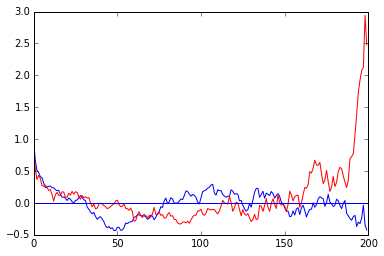

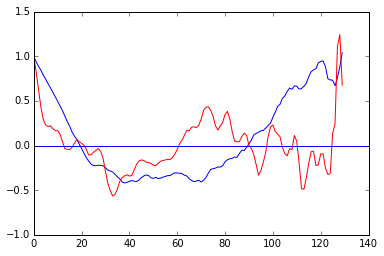

In [25]:
# grab subsets of each track, detrend them and do autocorrelation to get decorrelation length scale
# track 1

#plt.plot(t1x[0:100]/1000,detrend(t1int[0:100], order=1))
#plt.show()

#plt.plot(t3x[0:100]/1000,detrend(t3int[0:100], order=1))
#plt.show()
plt.hold(True)
plt.plot(ccf(detrend(t1int[100:300], order=1),detrend(t1int[100:300], order=1)),'b')
plt.plot(ccf(detrend(t1intT[100:300], order=1),detrend(t1intT[100:300], order=1)),'r')
plt.axhline()
plt.show()

plt.hold(True)
plt.plot(ccf(detrend(t3int[100:300], order=1),detrend(t3int[100:300], order=1)))
plt.plot(ccf(detrend(t3intT[100:300], order=1),detrend(t3intT[100:300], order=1)),'r')
plt.axhline()
plt.show()